### (Optional) Install Neural A* on Colab

We highly recommend the use of GPUs for faster training/planning.

In [ ]:
!git clone --recursive https://github.com/omron-sinicx/neural-astar

In [ ]:
%cd neural-astar
!pip install -U pip setuptools
!pip install .

## Shortest path search with Neural A* 

Neural A\*, as well as vanilla differentiable A\* can be instantiated just like a neural network module.

In [1]:
import torch
from neural_astar.planner import NeuralAstar, VanillaAstar
from neural_astar.utils.training import load_from_ptl_checkpoint

device = "cuda" if torch.cuda.is_available() else "cpu"

neural_astar = NeuralAstar(encoder_arch='CNN').to(device)
neural_astar.load_state_dict(load_from_ptl_checkpoint("../model/mazes_032_moore_c8/lightning_logs/"))

vanilla_astar = VanillaAstar().to(device)

/home/yonetani/programs/omron-sinicx/neural-astar/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


load ../model/mazes_032_moore_c8/lightning_logs/version_0/checkpoints/epoch=33-step=272.ckpt


Running these A\* modules requires `map_designs` (obstacle layouts), `start_maps`, and `goal_maps` (one-hot maps indicating start and goal locations), which should each have the shape of `(batch_size, 1, map_size, map_size)`.

Number of Test Samples: 100
	Size: 32x32


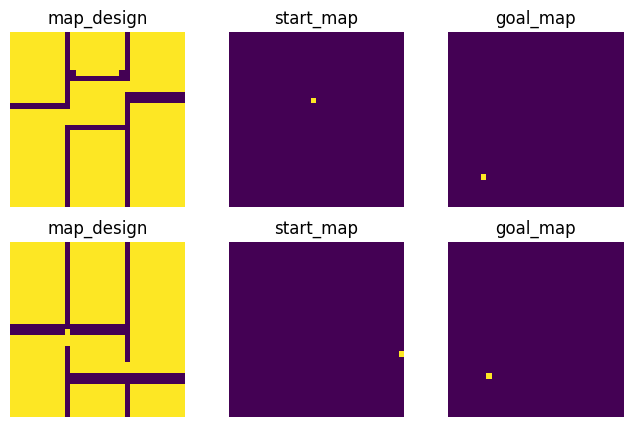

In [2]:
import matplotlib.pyplot as plt
from neural_astar.utils.data import create_dataloader

dataloader = create_dataloader("../planning-datasets/data/mpd/mazes_032_moore_c8.npz", "test", 8)
map_designs, start_maps, goal_maps, _ = next(iter(dataloader))

fig, axes = plt.subplots(2, 3, figsize=[8, 5])
for i in range(2):
    axes[i, 0].imshow(map_designs.numpy()[i, 0])
    axes[i, 0].set_title("map_design")
    axes[i, 0].axis("off")
    axes[i, 1].imshow(start_maps.numpy()[i, 0])
    axes[i, 1].set_title("start_map")
    axes[i, 1].axis("off")
    axes[i, 2].imshow(goal_maps.numpy()[i, 0])
    axes[i, 2].set_title("goal_map")
    axes[i, 2].axis("off")

Then, search can be performed by simply forwarding the model. The output is namedtuple `AstarOutput` with `histories` (search history maps) and `paths` (path maps).

/home/yonetani/programs/omron-sinicx/neural-astar/.venv/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


(-0.5, 273.5, 35.5, -0.5)

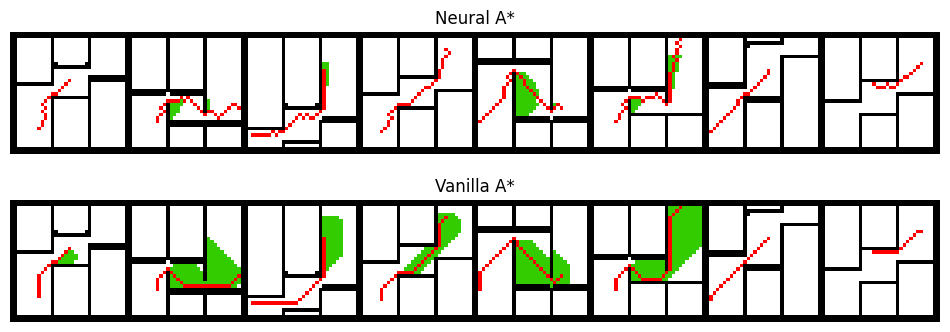

In [3]:
from neural_astar.utils.data import visualize_results

neural_astar.eval()
na_outputs = neural_astar(map_designs.to(device), start_maps.to(device), goal_maps.to(device))
vanilla_astar.eval()
va_outputs = vanilla_astar(map_designs.to(device), start_maps.to(device), goal_maps.to(device))

fig, axes = plt.subplots(2, 1, figsize=[12, 4])
axes[0].imshow(visualize_results(map_designs, na_outputs))
axes[0].set_title("Neural A*")
axes[0].axis("off")
axes[1].imshow(visualize_results(map_designs, va_outputs))
axes[1].set_title("Vanilla A*")
axes[1].axis("off")